In [1]:
import EOBRun_module
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.constants as const
import astropy.constants as aconst
from pycbc.waveform import td_approximants, fd_approximants, get_td_waveform
from pycbc.detector import Detector
from pycbc.filter import match, optimized_match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import timeseries
from scipy.optimize import minimize

In [2]:
# Global settings
sample_rate = 4096

# Calculating waveform

## Generating waveforms

In [3]:
# Generates EccentricTD waveform with given parameters
def gen_e_td_wf(f_low, e, M, q):
    m2 = M / (1+q)
    m1 = M - m2
    e_td_p, e_td_c = get_td_waveform(approximant='EccentricTD',
                                     mass1=m1,
                                     mass2=m2,
                                     eccentricity=e,
                                     delta_t=1.0/sample_rate,
                                     f_lower=f_low)
    return e_td_p, e_td_c

In [4]:
# Converts modes to use into language TEOBResumS understands
def modes_to_k(modes):
    return [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]

In [5]:
# Generates TEOBResumS waveform with given parameters
def gen_teob_wf(f_low, e, M, q):

    # Define parameters
    k = modes_to_k([[2,2]])
    print(M, q, f_low, e)
    pars = {
            'M'                  : M,
            'q'                  : q,
            'Lambda1'            : 0.,
            'Lambda2'            : 0.,     
            'chi1'               : 0.,
            'chi2'               : 0.,
            'domain'             : 0,            # TD
            'arg_out'            : 0,            # Output hlm/hflm. Default = 0
            'use_mode_lm'        : k,            # List of modes to use/output through EOBRunPy
            'srate_interp'       : sample_rate,  # srate at which to interpolate. Default = 4096.
            'use_geometric_units': 0,            # Output quantities in geometric units. Default = 1
            'initial_frequency'  : f_low,        # in Hz if use_geometric_units = 0, else in geometric units
            'interp_uniform_grid': 1,            # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
            'distance'           : 1,
            'inclination'        : 0,
            'ecc'                : e,
            'output_hpc'         : 0,
            }

    # Calculate waveform and convert to pycbc TimeSeries object
    t, teob_p, teob_c = EOBRun_module.EOBRunPy(pars)
    teob = teob_p - 1j*teob_c
    tmrg = t[np.argmax(np.abs(teob))]
    t = t - tmrg
    teob_p = timeseries.TimeSeries(teob_p, 1/sample_rate, epoch=t[0])
    teob_c = timeseries.TimeSeries(teob_c, 1/sample_rate, epoch=t[0])
    
    return teob_p, teob_c

In [6]:
# Generates waveform with given parameters and approximant
def gen_wf(f_low, e, M, q, approximant):

    # Chooses specified approximant
    if approximant=='EccentricTD':
        hp, hc = gen_e_td_wf(f_low, e, M, q)
    elif approximant=='TEOBResumS':
        hp, hc = gen_teob_wf(f_low, e, M, q)
    else:
        raise Exception('approximant not recognised')

    # Returns waveform as complex timeseries
    return hp - 1j*hc

## Varying true anomaly

In [7]:
# Calculates component masses from total mass and mass ratio
def m1_m2_from_M_q(M, q):
    m2 = M/(1+q)
    m1 = M - m2
    return m1, m2

In [8]:
# Calculates orbital period from gw frequency
def P_from_f(f):
    f_orb = f/2
    return 1/f_orb

In [9]:
# Uses Kepler's 3rd to get semi-major axis from period of orbit
def a_from_P(P, M):
    a_cubed = (const.G*M*P**2)/(4*np.pi**2)
    return a_cubed**(1/3)

In [10]:
# Calculates periastron advance per orbital revolution
def peri_advance_orbit(P, e, M):
    numerator = 6*np.pi*const.G*M
    a = a_from_P(P, M)
    denominator = const.c**2*a*(1-e**2)
    
    return numerator/denominator

In [11]:
# Calculates number of orbits for true anomaly to shift by 2pi
def num_orbits(P, e, M):
    delta_phi = peri_advance_orbit(P, e, M)
    n_orbit = (2*np.pi)/(2*np.pi - delta_phi)
    return n_orbit

In [12]:
# How much frequency is shifted by per orbit
def delta_freq_orbit(P, e, M, q):
    m1, m2 = m1_m2_from_M_q(M, q)
    numerator = 2*192*np.pi*(2*np.pi*const.G)**(5/3)*m1*m2*(1+(73/24)*e**2+(37/96)*e**4)
    denominator = 5*const.c**5*P**(8/3)*(m1+m2)**(1/3)*(1-e**2)**(7/2)
    return numerator/denominator

In [13]:
# Calculates what new shifted frequency should be such that true anomaly changes by 2pi
def shifted_f(f, e, M, q):
    M *= aconst.M_sun.value
    P = P_from_f(f)
    delta_f_orbit = delta_freq_orbit(P, e, M, q)
    n_orbit = num_orbits(P, e, M)
    return f - delta_f_orbit*n_orbit

In [14]:
# Calculates what new shifted frequency and eccentricity should be to shift such that true anomaly changes by 2pi
def shifted_e(s_f, f, e):
    s_e = e*(s_f/f)**(-19/18)
    return s_e

## Match waveforms

In [15]:
# Finds next highest power of two
def ceiltwo(number):
    ceil = math.ceil(np.log2(number))
    return 2**ceil

In [16]:
# Resize both waveform lengths to next highest power of two
def resize_wfs(wf1, wf2):
    tlen = ceiltwo(max(len(wf1), len(wf2)))
    wf1.resize(tlen)
    wf2.resize(tlen)
    return wf1, wf2

In [38]:
# Calculates match between two waveforms
def match_wfs(wf1, wf2, f_low, subsample_interpolation, return_phase=False):

    # Resize the waveforms to the same length
    wf1, wf2 = resize_wfs(wf1, wf2)

    # Generate the aLIGO ZDHP PSD
    delta_f = 1.0 / wf1.duration
    flen = len(wf1)//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

    # Perform match
    m = match(wf1.real(), wf2.real(), psd=psd, low_frequency_cutoff=f_low, subsample_interpolation=subsample_interpolation, return_phase=return_phase)

    # Additionally returns phase required to match waveforms up if requested
    if return_phase:
        return m[0], m[2]
    else:
        return m[0]

In [39]:
# Function to vary s_f to minimise match and find out of phase waveform
def minimise_match(s_f, f_low, e, M, q, h_fid, approximant, subsample_interpolation):

    # Calculate shifted eccentricity
    s_e = shifted_e(s_f[0], f_low, e)

    # Calculate trial waveform
    trial_wf = gen_wf(s_f[0], s_e, M, q, approximant)

    # Calculate match
    m = match_wfs(trial_wf, h_fid, s_f[0], subsample_interpolation)

    return m    

## Waveform components

In [19]:
# Gets waveform with given parameters at default true anomaly
def get_h_def(f_low, e, M, q, approximant):
    h_def = gen_wf(f_low, e, M, q, approximant)
    return h_def

In [41]:
# Gets waveform with given parameters out of phase with default true anomaly
def get_h_opp(f_low, e, M, q, h_def, approximant, opp_method, subsample_interpolation):

    # Gets amount to shift frequency by from equations in order to vary true anomaly by pi
    s_f_2pi = shifted_f(f_low, e, M, q)
    s_f_pi_len = 0.5*(f_low - s_f_2pi)

    # Calculates shifted frequency to vary anomaly by pi based on specified opp_method
    if opp_method == 'equation': # Simply takes result from approximate equations
        s_f_pi = f_low - s_f_pi_len
    elif opp_method == 'samples': # Refines result further by minimising match around local minimum
        args = (f_low, e, M, q, h_def, approximant, subsample_interpolation)
        bounds = [(f_low - 1.5*s_f_pi_len, f_low - 0.5*s_f_pi_len)]
        init_guess = f_low - (1.1 + 0.2*np.random.rand())*s_f_pi_len
        min_match_result = minimize(minimise_match, init_guess, args=args, bounds=bounds, method='Nelder-Mead')
        s_f_pi = min_match_result['x']
    else:
        raise Exception('opp_method not recognised')

    # Generates waveform
    s_e_pi = shifted_e(s_f_pi, f_low, e)
    h_opp = gen_wf(s_f_pi, s_e_pi, M, q, approximant)

    return h_opp 

## Overall waveform

In [112]:
# Gets overall waveform h = A*h1 + B*h2
def get_h(coeffs, f_low, e, M, q, approximant='EccentricTD', opp_method='equation', subsample_interpolation=True):

    # Gets h_def and h_opp components which make up overall waveform
    h_def = get_h_def(f_low, e, M, q, approximant)
    h_opp = get_h_opp(f_low, e, M, q, h_def, approximant, opp_method, subsample_interpolation)

    # Edits sample times of h_opp to match h_def
    first_ind = np.argmin(np.abs(h_def.sample_times[0]-h_opp.sample_times))
    h_opp = h_opp[first_ind:]
    h_def, h_opp = resize_wfs(h_def, h_opp)
    h_opp.start_time = h_def.start_time
    assert np.array_equal(h_def.sample_times, h_opp.sample_times)

    # Rotate h_opp by necessary amount to bring into phase with h_def
    _, phase_diff = match_wfs(h_def, h_opp, f_low, subsample_interpolation, return_phase=True)
    h_opp *= np.e**(-1j*phase_diff)

    # Identify h_ap and h_peri based on waveform approximant used
    if approximant=='EccentricTD':
        h_ap, h_peri = h_opp, h_def
    elif approximant=='TEOBResumS':
        h_ap, h_peri = h_def, h_opp
    else:
        raise Exception('approximant not recognised')

    # Calculate h1, h2 components of waveform
    h1 = 0.5*(h_ap + h_peri)
    h2 = 0.5*(h_ap - h_peri)

    # Returns overall waveform using complex coefficients A, B
    # Also returns components of waveform for testing purposes
    A, B = coeffs
    return A*h1 + B*h2, h1, h2, h_ap, h_peri

# Tests

In [146]:
h, h1, h2, h_ap, h_peri = get_h([1,1], 20, 0.1, 30, 2)

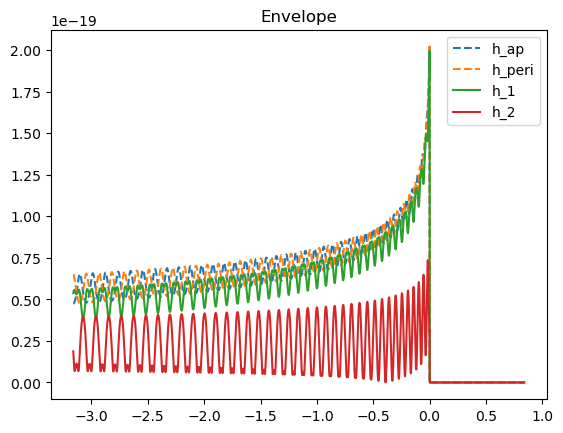

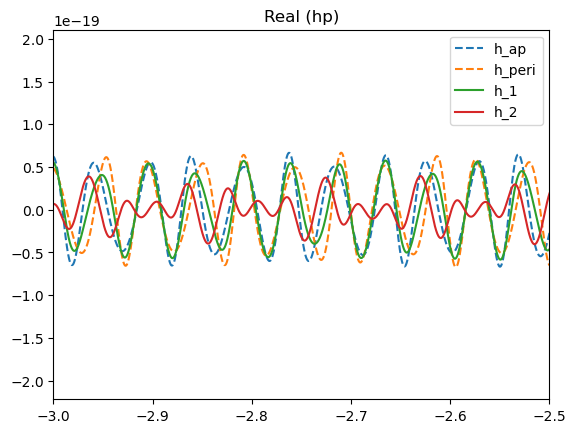

(-3.0, -2.5)

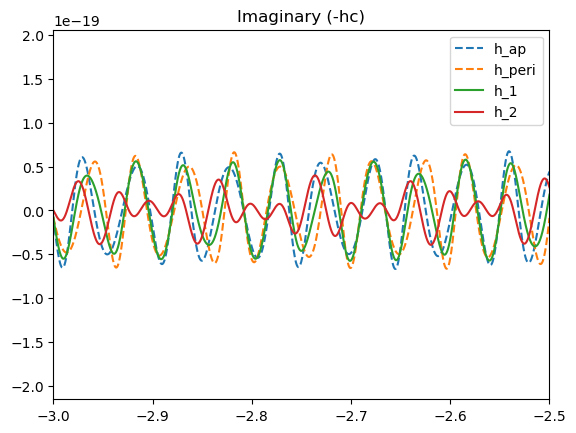

In [147]:
# Envelope
plt.plot(h.sample_times, np.sqrt(h_ap.real()**2+h_ap.imag()**2), ls='--', label='h_ap')
plt.plot(h.sample_times, np.sqrt(h_peri.real()**2+h_peri.imag()**2), ls='--', label='h_peri')
plt.plot(h.sample_times, np.sqrt(h1.real()**2+h1.imag()**2), label='h_1')
plt.plot(h.sample_times, np.sqrt(h2.real()**2+h2.imag()**2), label='h_2')
plt.title('Envelope')
plt.legend()
#plt.xlim(-0.5,-0.3)
plt.show()

# Real part (hp)
plt.plot(h.sample_times, h_ap.real(), ls='--', label='h_ap')
plt.plot(h.sample_times, h_peri.real(), ls='--', label='h_peri')
plt.plot(h.sample_times, h1.real(), label='h_1')
plt.plot(h.sample_times, h2.real(), label='h_2')
plt.title('Real (hp)')
plt.legend()
plt.xlim(-3,-2.5)
plt.show()

# Imaginary part (-hc)
plt.plot(h.sample_times, h_ap.imag(), ls='--', label='h_ap')
plt.plot(h.sample_times, h_peri.imag(), ls='--', label='h_peri')
plt.plot(h.sample_times, h1.imag(), label='h_1')
plt.plot(h.sample_times, h2.imag(), label='h_2')
plt.title('Imaginary (-hc)')
plt.legend()
plt.xlim(-3,-2.5)

In [155]:
h_ap_env = np.sqrt(h_ap.real()**2+h_ap.imag()**2)
h_peri_env = np.sqrt(h_peri.real()**2+h_peri.imag()**2)

h_1_env = 0.5*(h_ap_env + h_peri_env)
h_2_env = 0.5*(h_ap_env - h_peri_env)

A = 1
B = -1
h_env = A*h_1_env + B*h_2_env

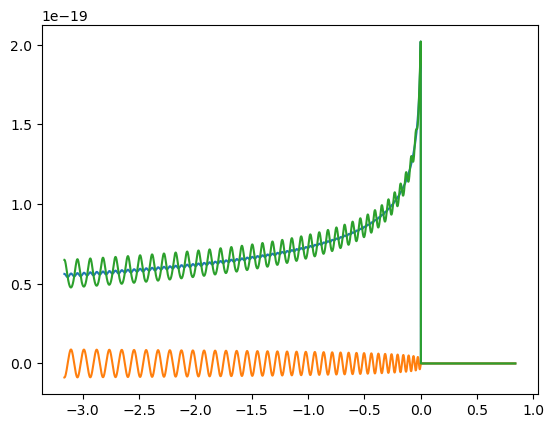

In [156]:
plt.plot(h_1_env.sample_times, h_1_env)
plt.plot(h_2_env.sample_times, h_2_env)
plt.plot(h_env.sample_times, h_env)